# Quick and dirty experiments

## Visualization of confidence intervals

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from crepes import WrapRegressor

In [2]:
dataset = fetch_openml(name="house_sales", version=3, parser="auto")
    
X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.25)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_prop_train = scaler_X.fit_transform(X_prop_train)
X_cal = scaler_X.transform(X_cal)
X_test = scaler_X.transform(X_test)

y_prop_train = scaler_y.fit_transform(y_prop_train.reshape(-1,1)).ravel()
y_cal = scaler_y.transform(y_cal.reshape(-1,1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1,1)).ravel()

print("Training set: %d samples" % X_prop_train.shape[0])
print("Calibration set: %d samples" % X_cal.shape[0])
print("Test set: %d samples" % X_test.shape[0])  

print("Training regressor...")
rf = WrapRegressor(RandomForestRegressor())
rf.fit(X_prop_train, y_prop_train)

print("Calibrating regressor...")
rf.calibrate(X_cal, y_cal)

Training set: 8104 samples
Calibration set: 2702 samples
Test set: 10807 samples
Training regressor...
Calibrating regressor...


WrapRegressor(learner=RandomForestRegressor(), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

In [3]:
y_pred = rf.predict(X_test)
y_pred_ci = rf.predict_int(X_test, confidence=0.95)
print(y_pred)
print(y_pred_ci)

[-0.78818207 -0.27118259  0.22209009 ...  1.28104743 -0.08562785
  0.09180229]
[[-1.38098812 -0.19537602]
 [-0.86398864  0.32162346]
 [-0.37071596  0.81489614]
 ...
 [ 0.68824138  1.87385348]
 [-0.6784339   0.5071782 ]
 [-0.50100376  0.68460834]]


[[-1.38098812 -0.19537602]
 [-0.86398864  0.32162346]
 [-0.37071596  0.81489614]
 ...
 [ 0.68824138  1.87385348]
 [-0.6784339   0.5071782 ]
 [-0.50100376  0.68460834]]


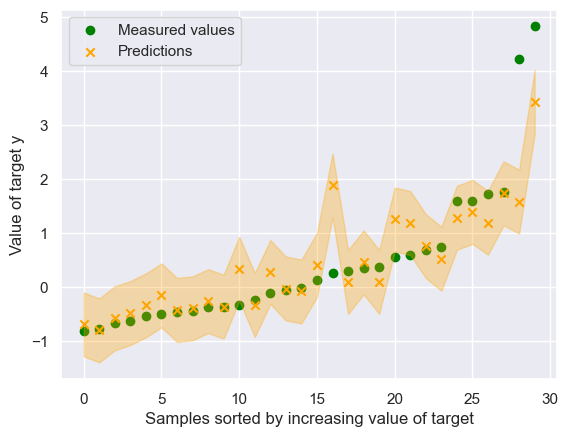

In [4]:
def plot_confidence_intervals(y, y_pred, y_pred_ci) :
    """
    
    """
    # sort y_test values from small to big, along with y_pred_ci
    # using a list is pretty slow, there is probably a smarter way to do this
    # with numpy arrays, but the data set sizes should be small, so who cares
    y_and_ci = []
    for i in range(0, len(y)) :
        y_and_ci.append([y[i], y_pred[i], y_pred_ci[i]])
    y_and_ci = sorted(y_and_ci, key=lambda x : x[0])
    
    fig, ax = plt.subplots()
    
    # plot measured values and point predictions for y
    x = range(0, len(y))
    ax.scatter(x, [x[0] for x in y_and_ci], marker='o', color='green', label="Measured values")
    ax.scatter(x, [x[1] for x in y_and_ci], marker='x', color='orange', label="Predictions")
    
    # visualize corresponding confidence intervals around point predictions
    ax.fill_between(x, [x[2][0] for x in y_and_ci], 
                    [x[2][1] for x in y_and_ci], 
                    color='orange', alpha=0.3)
    
    ax.set_xlabel("Samples sorted by increasing value of target")
    ax.set_ylabel("Value of target y")
    ax.legend(loc='best')
    
    return fig, ax

sns.set_theme()
fig, ax = plot_confidence_intervals(y_test[-30:], y_pred[-30:], y_pred_ci[-30:])
print(y_pred_ci)

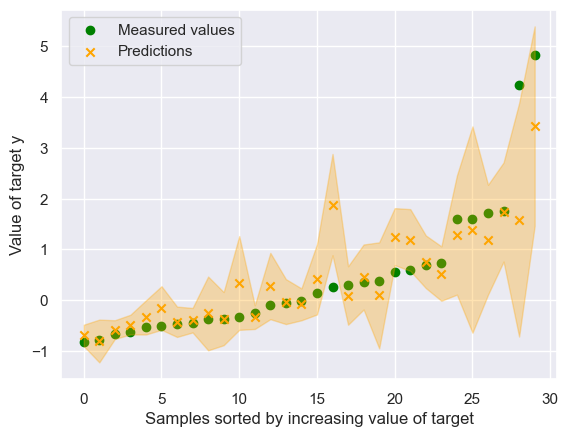

In [5]:
# what about a Mondrian estimator? normally it should provide smaller confidence intervals
# we first need a difficulty estimator
from crepes.extras import DifficultyEstimator
de = DifficultyEstimator()
de.fit(X_prop_train, y=y_prop_train)
sigmas_cal = de.apply(X_cal)

rf.calibrate(X_cal, y_cal, sigmas=sigmas_cal)
sigmas_test = de.apply(X_test)
y_pred_ci = rf.predict_int(X_test, sigmas=sigmas_test)

fig, ax = plot_confidence_intervals(y_test[-30:], y_pred[-30:], y_pred_ci[-30:])